In [2]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.model_selection import train_test_split
from utils.visualizer import Visualizer
from IPython.display import SVG, display
from sklearn.metrics import precision_recall_curve

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle
import sklearn
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [4]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt].astype(np.float32), targets[excerpt].astype(np.float32)


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2].astype(np.float32), y_val[:2].astype(np.float32))
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()

# Build the dataset

In [ ]:
JPEG_FOLDER = '../data/VOCdevkit/VOC2012/JPEGImages'
ims = []

for fname in os.listdir(JPEG_FOLDER):
    ims.append(plt.imread(os.path.join(JPEG_FOLDER, fname)))

In [ ]:
import scipy as sp

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def crop(img):    
    img = rgb2gray(img)
    
    if img.shape[0] > img.shape[1]:
        img = sp.ndimage.rotate(img, 90)
        
    return sp.misc.imresize(img, [350, 500])

In [ ]:
base = np.asarray(map(crop, ims))

In [15]:
with open('../data/mnist.pkl') as f:
    dataset = pickle.load(f)

In [16]:
train = dataset[0][0].reshape(-1, 28, 28)
val = dataset[1][0].reshape(-1, 28, 28)
test = dataset[2][0].reshape(-1, 28, 28)

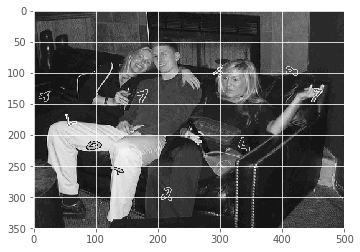

In [88]:
i = X_y[1][0].reshape(350, 500)
plt.imshow(i, cmap=plt.cm.Greys_r)
plt.imsave('../im1.png', i, cmap=plt.cm.Greys_r)

In [78]:
digits = (np.vstack([train, val, test]) * 255).astype(np.uint8)

In [ ]:
train_labels = dataset[0][1]
val_labels = dataset[1][1]
test_labels = dataset[2][1]

In [ ]:
labels = np.hstack([train_labels, val_labels, test_labels])

In [ ]:
import itertools

cells = list(itertools.product(range(350 / 40), range(500 / 40)))

In [ ]:
def add_digits(img, digits, labels, target, size):
    pad_idxs = np.random.choice(range(len(cells)), size=size, replace=False)
    tmp = img.copy()
    answer = np.zeros_like(img)

    for i in range(size):
        x, y = np.array(cells[pad_idxs[i]]) * 40
        digit_idx = np.random.choice(digits.shape[0])
        label = labels[digit_idx]
        tmp2 = sp.ndimage.rotate(digits[digit_idx], np.random.randint(360))
        tmp2[tmp2 <= 0.5 * 255] = 0
        tmp2[tmp2 > 0.5 * 255] = 255

        tmp2[tmp2 >= 255*0.5] = 255
        tmp2[tmp2 < 255*0.5] = 0

        blured = sp.ndimage.gaussian_filter(tmp2, sigma=0.5)

        tmp2 = blured.astype(np.int64) - tmp2.astype(np.int64)

        tmp22 = np.zeros_like(tmp2)

        tmp22[tmp2 >= 0] = (tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]].mean() + 128) % 256
        tmp22[tmp2 < 0] = tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]].mean()
        tmp22[tmp2 == 0] = tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]][tmp2 == 0]

        tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]] = tmp22
        
        if label == target:
            answer[x:x + tmp2.shape[0], y:y + tmp2.shape[1]] = 1
        
    return tmp, answer
   
size = 10
target = 7
plt.figure(figsize=(10,10))
plt.imshow(add_digits(base[10050], digits, labels, target, size)[0], cmap=plt.cm.Greys_r)
plt.grid('off')

In [38]:
dataset = []
targets = []
target = 7
size = 10

for img in base:
    new_img, answer = add_digits(img, digits, labels, target, size)
    dataset.append(new_img)
    targets.append(answer)

In [ ]:
dataset = np.asarray(dataset)
targets = np.asarray(targets)

In [5]:
dataset = np.load('../data/artificial_dataset1.npy')
targets = np.load('../data/artificial_dataset1_targets.npy')

In [ ]:
np.save('../data/artificial_dataset1', dataset)

In [ ]:
np.save('../data/artificial_dataset1_targets', targets)

In [6]:
# cascade_builder(input_layer, num_filters, filter_size, pool_size)
# num_filters
# filter_size
# pool_size
#
# Returns: cascade, complaxity
def cascade_builder(input_layer, num_filters, filter_size, pool_size):
    cascade0 = lasagne.layers.Conv2DLayer(input_layer,
                                          num_filters=num_filters,
                                          filter_size=filter_size,
                                          nonlinearity=lasagne.nonlinearities.elu,
                                          pad='same')
#     cascade1 = lasagne.layers.Conv2DLayer(cascade0,
#                                           num_filters=num_filters,
#                                           filter_size=filter_size,
#                                           nonlinearity=lasagne.nonlinearities.elu,
#                                           pad='same')
    cascade = lasagne.layers.MaxPool2DLayer(cascade0, pool_size=pool_size)
    
    complexity = np.prod(cascade0.filter_size) * cascade0.num_filters
    
    return cascade, complexity

In [7]:
from models.buldozer import Buldozer

In [38]:
params = ((4, 3, 4),
          (8, 3, 2), 
          (16, 3, 2),
          (32, 3, 2),
          (64, 3, 2))
buldozer = Buldozer(
                    [cascade_builder] * 5,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 0.0, 0.0, 1e-0, 0.0],
                    c_sub_obj_cs = [0.0, 0.0, 0.0, 1e-1, 0.0],
                    c_complexity=0.0001,
                    c_obj=1
                   )

In [39]:
buldozer.load('../weights', 'buldozer_pre_3')

In [10]:
X_y = train_test_split(dataset.reshape(-1, 1, 350, 500), targets.reshape(-1, 1, 350, 500), random_state=42)

In [40]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy', 
               'loss', 
               'sub_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=150
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MemoryError: Error allocating 5760000 bytes of device memory (out of memory).
Apply node that caused the error: GpuAllocEmpty(Assert{msg='The convolution would produce an invalid shape (dim[0] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[1] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[2] <= 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[3] <= 0).'}.0)
Toposort index: 328
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(150), array(64), array(10), array(15)]
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [67]:
buldozer.evaluate(X_y[1][:100], X_y[-1][:100])

{'accuracy': array(0.9354285714285714),
 'complexity_parts': array([ 0.42845428,  0.54573381,  0.6050334 ,  0.62806576], dtype=float32),
 'loss': array(0.19256865978240967, dtype=float32),
 'obj': array(0.3937261997900603),
 'precision': array(0.44936707615852356),
 'recall': array(0.3380952477455139, dtype=float32),
 'sub_loss': array(0.20063117146492004, dtype=float32),
 'total_complexity': array(0.526368517729429)}

In [16]:
buldozer.save('../weights/', 'buldozer_pre_1')

In [20]:
buldozer.save('../weights/', 'buldozer_pre_2')

In [25]:
buldozer.save('../weights', 'buldozer_pre_3')

In [14]:
import theano

get_target = theano.function([buldozer.targets], lasagne.layers.get_output(buldozer.target_pool_layers[-1]))

def draw_precision_recall(network, x_val, y_val):
    prediction = network.predict(x_val)
    target = get_target(y_val)

    precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
    plt.xlabel('Recall')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc='best')
    plt.show()
    
    for r in [0.90, 0.95, 0.99, 0.999]:
        print 'Recall:', recall[np.max(np.where(recall >= r))]
        print 'Precision:', precision[np.max(np.where(recall >= r))]
        print

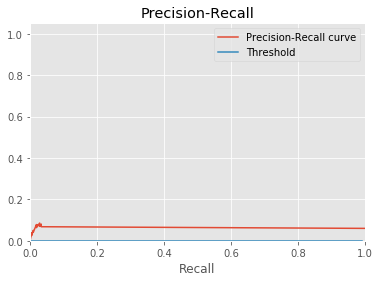

Recall: 1.0
Precision: 0.06

Recall: 1.0
Precision: 0.06

Recall: 1.0
Precision: 0.06

Recall: 1.0
Precision: 0.06



In [15]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

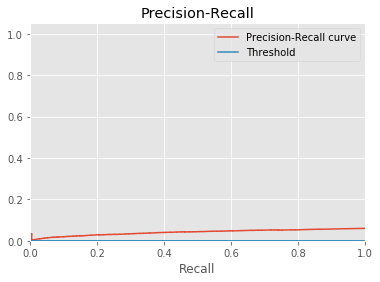

Recall: 0.9
Precision: 0.0568250150331

Recall: 1.0
Precision: 0.06

Recall: 1.0
Precision: 0.06

Recall: 1.0
Precision: 0.06



In [24]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

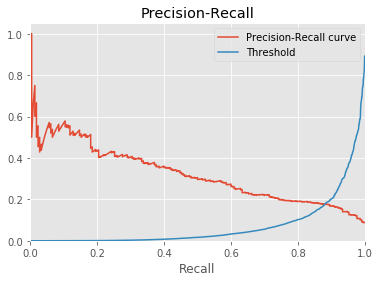

Recall: 0.9
Precision: 0.168

Recall: 0.952380952381
Precision: 0.138408304498

Recall: 0.990476190476
Precision: 0.101761252446

Recall: 1.0
Precision: 0.0882723833544



In [37]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

In [43]:
X_y[1][:100].shape

(100, 1, 350, 500)

In [44]:
X_y[-1][:100].shape

(100, 1, 350, 500)

In [ ]:
print 1